In [ ]:
!pip install nltk

In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=9de8f2a11d716e2636609a284847dfbccf50e95e45cb45b77f40425123753545
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
import pandas as pd
import math
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from scipy.stats import randint
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def calculate_halstead(text):
  if not isinstance(text, str):
    return 0
  tokens = text.split()
  tokens = [token.lower() for token in tokens]
  unique_tokens = set(tokens)
  halstead = math.log(len(unique_tokens), 2) * len(tokens) if tokens else 0
  return halstead


def calculate_ttr(text):
  if not isinstance(text, str):
    return 0
  tokens = text.split()
  tokens = [token.lower() for token in tokens]
  unique_tokens = set(tokens)
  ttr = len(unique_tokens) / len(tokens) if tokens else 0
  return ttr

In [ ]:

df = pd.read_csv("./data/answerList_data.csv")
df = df.drop(['Answer.ID','Question.ID', 'TP', 'TN', 'FP', 'FN', 'Answer.option', 'Answer.order', 'Code.LOC', 'Code.complexity', 'Worker.ID', 'Worker.yearsOfExperience', 'Worker.age', 'Worker.gender', 'Worker.whereLearnedToCode', 'Worker.country', 'Worker.programmingLanguage'], axis=1)
df['halstead'] = df['Answer.explanation'].apply(lambda x: calculate_halstead(x))
df['ttr'] = df['Answer.explanation'].apply(lambda x: calculate_ttr(x))
df['len'] = df['Answer.explanation'].apply(lambda x: len(str(x)))


In [ ]:
# With embeddings
# Expand embeddings into separate features
# embeddings = np.vstack(df['embedding'].to_numpy())
# pca = PCA(n_components=50)
# embeddings = pca.fit_transform(embeddings)
# embedding_columns = [f'embedding_{i+1}' for i in range(embeddings.shape[1])]
# embedding_df = pd.DataFrame(embeddings, columns=embedding_columns)
# # Merge expanded embeddings back into the original DataFrame
# df = pd.concat([df.drop(columns=['Answer.explanation', 'embedding']), embedding_df], axis=1)


In [ ]:
df = df.drop(['Answer.explanation'], axis = 1)
# df = df.drop(['halstead'], axis = 1)
df = df.drop(['ttr'], axis = 1)

In [ ]:
min_value = df['Answer.duration'].min()
max_value = df['Answer.duration'].max()
df['Answer.duration'] = df['Answer.duration'].apply(lambda x: (x - min_value) / (max_value - min_value))
min_value = df['halstead'].min()
max_value = df['halstead'].max()
df['halstead'] = df['halstead'].apply(lambda x: (x - min_value) / (max_value - min_value))

one_hot_profession = pd.get_dummies(df["Worker.profession"], prefix="profession")
one_hot_profession = one_hot_profession.astype(int)
df = pd.concat([df, one_hot_profession], axis=1)
df = df.drop(['Worker.profession'], axis= 1)
df.head()


KeyError: 'Worker.profession'

In [ ]:
# extract Bug reports of type HIT01_8 and HIT07_33 to the holdout set
test_set = df[df['FailingMethod'].isin(["HIT01_8", "HIT07_33"])]
train_set = df[~df['FailingMethod'].isin(["HIT01_8", "HIT07_33"])]

X_train = train_set.drop(['GroundTruth', 'FailingMethod'], axis = 1)
y_train = train_set['GroundTruth']

X_test = test_set.drop(['GroundTruth', 'FailingMethod'], axis = 1)
y_test = test_set['GroundTruth']

In [ ]:
for string in ['HIT01_8','HIT02_24','HIT03_6','HIT04_7','HIT05_35','HIT06_51','HIT07_33','HIT08_54']:
  test_set_b = df[df['FailingMethod'].isin([string])]
  print("ratio for : ", string, test_set_b['GroundTruth'].sum() / len(test_set_b))
train_set = train_set

ratio for :  HIT01_8 0.2
ratio for :  HIT02_24 0.3333333333333333
ratio for :  HIT03_6 0.23529411764705882
ratio for :  HIT04_7 0.13513513513513514
ratio for :  HIT05_35 0.3333333333333333
ratio for :  HIT06_51 0.16666666666666666
ratio for :  HIT07_33 0.375
ratio for :  HIT08_54 0.125


In [ ]:
clf = RandomForestClassifier()

param_dist = {
    'n_estimators' : randint(50, 1000),
    'max_depth' : [15, 20, 25, 30, 35, 40, 45, 50, None],
    'min_samples_split' : randint(2, 6),
    'criterion' : ['gini', 'entropy']
}

random_search = RandomizedSearchCV(estimator = clf, param_distributions = param_dist, n_iter = 20, cv = 5, scoring= 'f1')
random_search.fit(X_train, y_train)
print("random search best params: ", random_search.best_params_)
best_model= random_search.best_estimator_

random search best params:  {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 698}


In [ ]:
y_pred_train = best_model.predict(X_train)

print("Scores Train")
print("recall: ", recall_score(y_train, y_pred_train), "\nprecision: ", precision_score(y_train, y_pred_train))
print("f1: ", f1_score(y_train, y_pred_train))

y_pred_test = best_model.predict(X_test)
print("Scores Test")
print("recall: ", recall_score(y_test, y_pred_test), "\nprecision: ", precision_score(y_test, y_pred_test))
print("f1: ", f1_score(y_test, y_pred_test))

Scores Train
recall:  0.74 
precision:  1.0
f1:  0.8505747126436781
Scores Test
recall:  0.04 
precision:  0.6666666666666666
f1:  0.07547169811320754


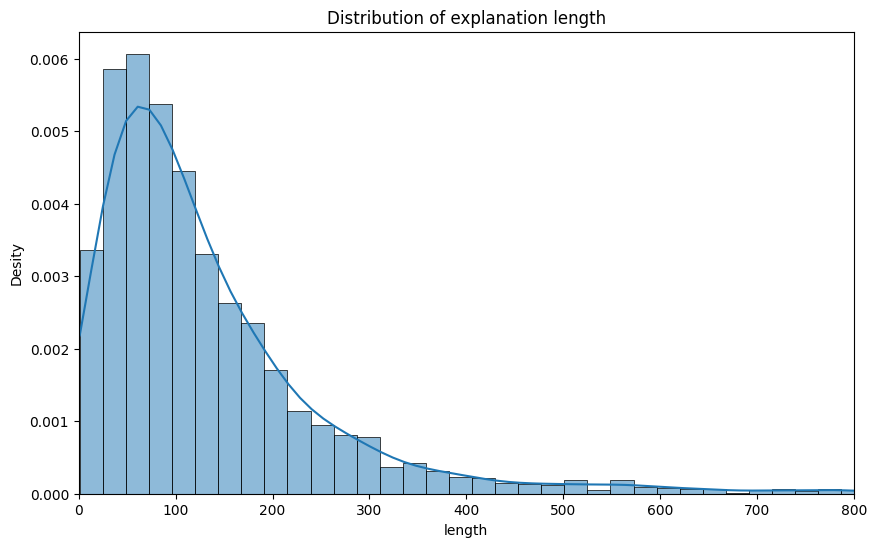

In [ ]:
# Explanation size
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='len', bins=100, kde=True, stat='density')
plt.title('Distribution of explanation length')
plt.xlabel('length')
plt.ylabel('Desity')
plt.xlim(0, 800)
plt.show()

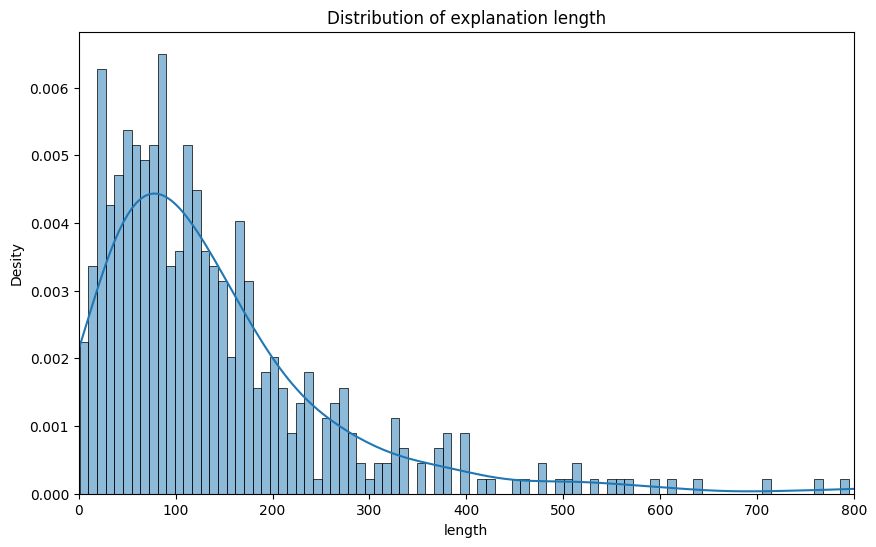

In [ ]:
# Explanation size
true_label_df = df[df['GroundTruth'] != 0]
plt.figure(figsize=(10, 6))
sns.histplot(data=true_label_df, x='len', bins=100, kde=True, stat='density')
plt.title('Distribution of explanation length')
plt.xlabel('length')
plt.ylabel('Desity')
plt.xlim(0, 800)
plt.show()

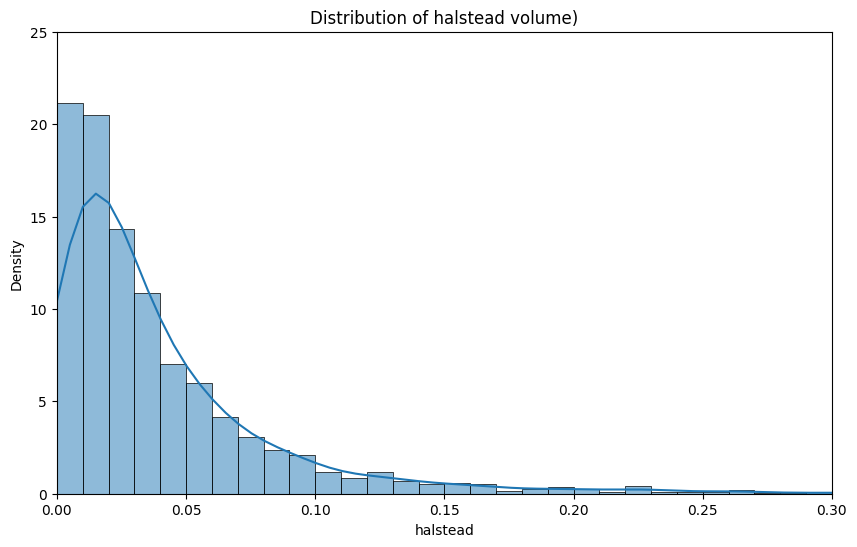

In [ ]:
# Explanation complexity
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='halstead', bins=100, kde=True, stat='density')
plt.title('Distribution of halstead volume)')
plt.xlabel('halstead')
plt.ylabel('Density')
plt.xlim(0, 0.3)
plt.ylim(0, 25)
plt.show()

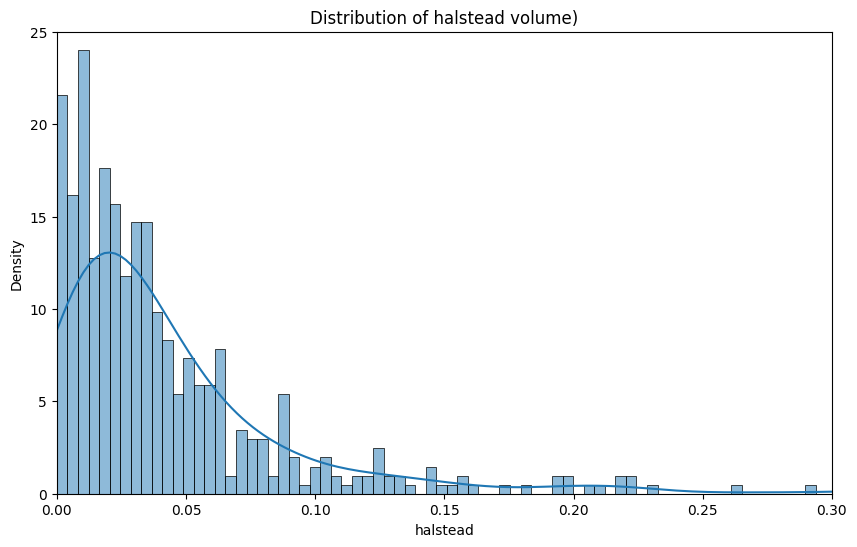

In [ ]:
# Explanation complexity
plt.figure(figsize=(10, 6))
sns.histplot(data=true_label_df, x='halstead', bins=100, kde=True, stat='density')
plt.title('Distribution of halstead volume)')
plt.xlabel('halstead')
plt.ylabel('Density')
plt.xlim(0, 0.3)
plt.ylim(0, 25)
plt.show()

# Task 2

In [ ]:
data = pd.read_csv("./data/answerList_data.csv")
data = data.drop(['Answer.ID','Question.ID', 'TP', 'TN', 'Answer.option', 'Answer.order', 'Code.LOC', 'Code.complexity', 'Worker.ID', 'Worker.yearsOfExperience', 'Worker.age', 'Worker.gender', 'Worker.whereLearnedToCode', 'Worker.country', 'Worker.programmingLanguage'], axis=1)

for bug in ['HIT01_8','HIT02_24','HIT03_6','HIT04_7','HIT05_35','HIT06_51','HIT07_33','HIT08_54']:
  print(bug)
  test = data[data['FailingMethod'].isin([bug])]
  test = test[test['FP'] != 1]
  test = test[test['FN'] != 1]
  test = test[test['GroundTruth'] == 1]
  output = ""
  for x in test['Answer.explanation']:
    output += x + "\n"
  print(output)



HIT01_8
Minutes are set to -15; which is less then 0 and it throws illegal arg exception
In the code there is a check that 0 <= minutes < 60 and the minutesOffset is -15 which does not fall into these prarmeters thus throwing an Exception
There is a logical check for if minuteOffset is less than 0 or greater than 59 causing it to throw an exception because the value is out of bounds (negative number)
YES. The issue is on line 279 (as I explained in my first question; of which I misunderstood that I was only being asked about the specific issue; not generalized issue). On line 279 the variable "minutesOffSet" is parameterized to throw an exception if it is < 0 or > 59. Line 279 should read "if (minutesOffset < -59 || minutesOffset > 59) {" because now the method can take in the number of minutes as a negative and will allow the method to properly progress to invoke/call further methods such as those asked about in the two previous questions.
The variable "minutesOffset" is checked incor

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
bug1_reference = []
bug1_reference_rouge = ""
bug1_gpt = "The failure occurs because the program incorrectly increments the pos variable without validating it against the bounds of the input CharSequence (lines 89 and 95), causing a StringIndexOutOfBoundsException during Unicode character handling in a loop that does not properly account for edge cases like empty input, surrogate pairs, or mismatched consumed values."

gpt_prompts = ["The issue stems from the conditional check on line 279 of the code. The variable minutesOffset is being validated with the condition if (minutesOffset < 0 || minutesOffset > 59). This check incorrectly rejects any negative value for minutesOffset, such as the value -15 passed as an argument in the method call DateTimeZone.forOffsetHoursMinutes(-2, -15). According to the documentation and comments, minutesOffset should be allowed to have negative values when associated with a negative hour offset, with valid ranges between -59 and 59. However, the current implementation of the check does not account for this and treats all negative values as invalid. Consequently, the code throws an IllegalArgumentException on line 280, with the message indicating that the minutes value is out of range. To resolve this issue, the conditional on line 279 should be updated to validate the range correctly. For instance, it should check if (minutesOffset < -59 || minutesOffset > 59) to allow valid negative offsets. Additionally, the logic should be refined to ensure compatibility between hoursOffset and minutesOffset, as specified in the documentation. This misalignment between the comment block and the actual condition in the code underscores the importance of keeping comments and code synchronized to prevent misunderstandings.",
               "The issue occurs because the minutesOffset variable is set to -15 through DateTimeZone.forOffsetHoursMinutes(-2, -15), but the condition on line 279 checks if (minutesOffset < 0 || minutesOffset > 59). This incorrectly rejects all negative values, contrary to the documentation stating valid ranges are -59 to 59. To fix the bug, the condition should be updated to if (minutesOffset < -59 || minutesOffset > 59) to account for negative offsets as intended. The current check results in an IllegalArgumentException when minutesOffset is negative, such as -15.",
               ""]

for bug in ['HIT03_6']:
  test = data[data['FailingMethod'].isin([bug])]
  test = test[test['FP'] != 1]
  test = test[test['FN'] != 1]
  test = test[test['GroundTruth'] == 1]
  output = ""
  for x in test['Answer.explanation']:
    bug1_reference += [x.split()]
    bug1_reference_rouge += '"' + x + '"' + ', '
  print(bug1_reference_rouge)
  print(sentence_bleu(bug1_reference, bug1_gpt.split()))

  scorer = rouge_scorer.RougeScorer(rouge_types=['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)
  scores = scorer.score(bug1_reference_rouge, bug1_gpt)
  print(scores)


"The input "\uD83D\uDE30" needs to be passed through the Class StringEscapeUtils as well.", "Ok I get it; it is an issue with index numbers being less than the length ", "Checking a character in the string with pos most likely causes an error since the error is a string out of bounds", "On line 85; a recursive call is made to the function with an improper number of arguments and expecting a return value.", "The while loop has a potential to be infinite if the array c is null (I believe Java allows arrays of size 0). ", "I'm a little fuzzy on what is going on with this code because I'm not up on all the details of handling unicode but the purpose of this sections seems to be dealing with the fact that in things like UTF-8 sometimes you get characters that are one byte and sometimes 2. Anyway; the issue seems to be with the for loop on line 94. We are incrementing the variable pt and checking that it is less than consumed but we are accessing the input via the pos variable.    If consume